<a href="https://colab.research.google.com/github/Jack-Cruz/Administracion_Informacion/blob/main/09_examen_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_multiotsu
import numpy as np
from scipy.ndimage.morphology import binary_erosion, binary_dilation

In [2]:
base = "https://canaval.org/assets/"

In [3]:
avionesfn = "Aviones.jpg"
file = f"{base}{avionesfn}"
!curl -O $file

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  165k  100  165k    0     0  1855k      0 --:--:-- --:--:-- --:--:-- 1876k


(<matplotlib.image.AxesImage at 0x7ff2d5653590>, (-0.5, 399.5, 514.5, -0.5))

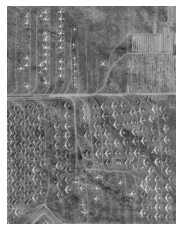

In [4]:
im = rgb2gray(imread(avionesfn))
plt.imshow(im, cmap='gray'), plt.axis('off')

(<matplotlib.image.AxesImage at 0x7ff2d414d1d0>, (-0.5, 399.5, 514.5, -0.5))

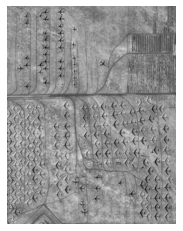

In [5]:
im1 = 1 - im
plt.imshow(im1, cmap='gray'), plt.axis('off')

(<matplotlib.image.AxesImage at 0x7ff2d4124390>, (-0.5, 399.5, 514.5, -0.5))

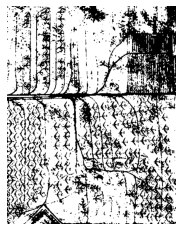

In [6]:
# hallamos un threshold, no ayuda ya que hay un gran espacio blanco
thres = threshold_otsu(im1)
im2 = (im1 > thres).astype(np.uint8)

plt.imshow(im2, cmap='gray'), plt.axis('off')

(<matplotlib.image.AxesImage at 0x7ff2d4083750>, (-0.5, 399.5, 514.5, -0.5))

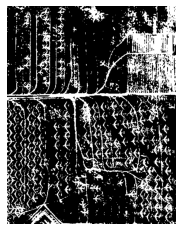

In [7]:
# hallamos un threshold con rango
thres = threshold_otsu(im1)
thres_min = thres - 1
im3 = ((im > thres) & (im > thres_min)).astype(np.uint8)

plt.imshow(im3, cmap='gray'), plt.axis('off')

(-0.5, 399.5, 514.5, -0.5)

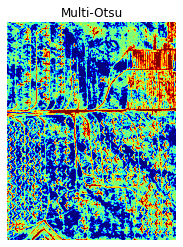

In [8]:
# hallamos un multi threshold, pero se obtiene un resultado apropiado
thresholds = threshold_multiotsu(im)
im4 = np.digitize(im, bins=thresholds)

plt.imshow(im4, cmap='jet')
plt.title('Multi-Otsu')
plt.axis('off')

In [9]:
# Usamos openging and closing a los elementos del otsu range (im3)
aux1 = im3.copy()
aux2 = binary_erosion(aux1, structure=np.ones((1, 2)))
aux3 = binary_erosion(aux1, structure=np.ones((2, 2)))
aux4 = binary_dilation(aux3, structure=np.ones((2, 2)))
aux5 = binary_erosion(aux4, structure=np.ones((1, 1)))
aux6 = 1 - im2

Text(0.5, 1.0, 'inv')

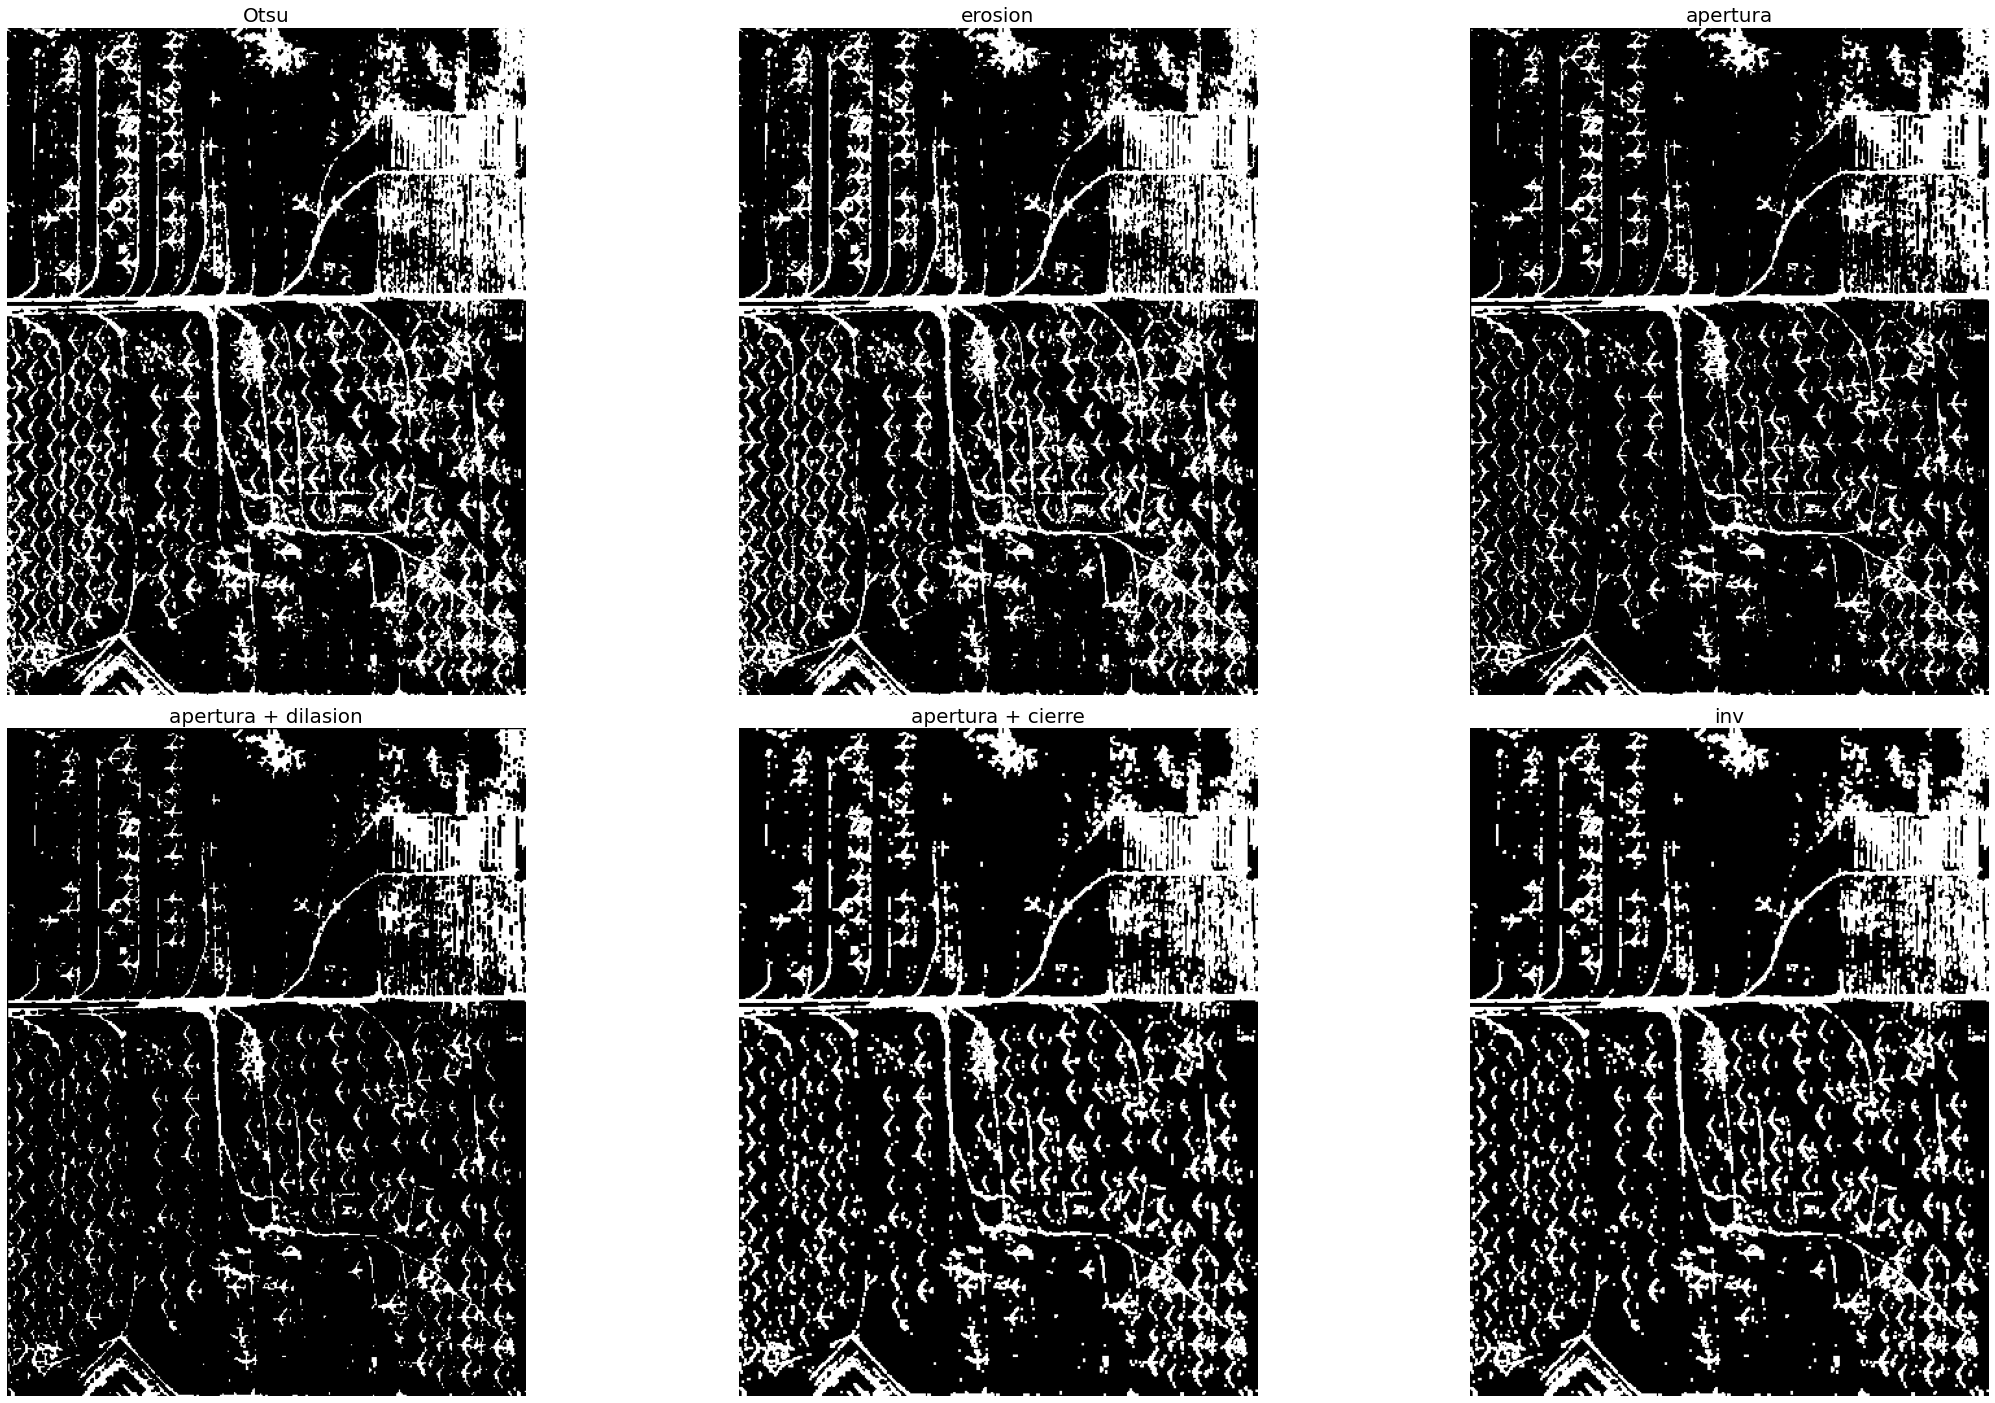

In [10]:
plt.figure(figsize=(30, 20))
plt.gray()
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, hspace=0.05, wspace=0.05)

plt.subplot(231), plt.imshow(im3), plt.axis('off')
plt.title('Otsu', size=20)

plt.subplot(232), plt.imshow(aux1), plt.axis('off')
plt.title('erosion', size=20)

plt.subplot(233), plt.imshow(aux2), plt.axis('off')
plt.title('apertura', size=20)

plt.subplot(234), plt.imshow(aux3), plt.axis('off')
plt.title('apertura + dilasion', size=20)

plt.subplot(235), plt.imshow(aux4), plt.axis('off')
plt.title('apertura + cierre', size=20)

plt.subplot(236), plt.imshow(aux5), plt.axis('off')
plt.title('inv', size=20)

## 1° versión
El primer procesimiento consiste en usar el otsu con rango, luego usar closing-opening, además, recorrer los espacios con una simulación del algorítmo DFS.

In [11]:
dx = [-1, -1, -1, 0, 0, 1, 1, 1]
dy = [-1, 0, 1, -1, 1, -1, 0, 1]

def DFS(x, y, n, m, im, vis):
  if vis[x, y] == 1: return 
  for i in range(8):
    vx = x + dx[i]
    vy = y + dy[i]

    if (vx < 0) | (vy < 0) | (vx >= n) | (vy >= m):
      continue 

    if (im[vx, vy] == 1) & (vis[vx, vy] == 0):
      vis[x, y] = 1
      vis = DFS(vx, vy, n, m, im, vis)

  return vis

def version1(im):
  # theshold rango
  im1 = 1 - im
  thres = threshold_otsu(im1)
  thres_min = thres - 1
  im3 = ((im > thres) & (im > thres_min)).astype(np.uint8)

  aux1 = im3.copy()
  aux2 = binary_erosion(aux1, structure=np.ones((1, 2)))  
  aux3 = binary_erosion(aux1, structure=np.ones((2, 2)))
  aux4 = binary_dilation(aux3, structure=np.ones((2, 2)))
  aux5 = binary_erosion(aux4, structure=np.ones((1, 1)))

  n, m = aux2.shape
  vis = np.zeros((n, m))

  ans = 0
  for i in range(n):
    for j in range(m):
      if (aux5[i, j] == 1) & (vis[i, j] == 0):
        ans += 1
        vis = DFS(i, j, n, m, aux5, vis)

  print("Total de aviones: ", ans)


In [ ]:
# Importante,  ha crasheado el programa despues de esta linea de codigo
# version1(im)

## 2° versión
El segundo procesimiento consiste en usar el fft (fast fourier transform), dado que los aviones se encuentra en cierto orden y se puede detectar el patrón, luego se resaltaría los espacios y finalmente, como un algoritmo similar al DFS se puede contar los espacios en blanco.

In [17]:
import numpy.fft as fft
from matplotlib.colors import LogNorm

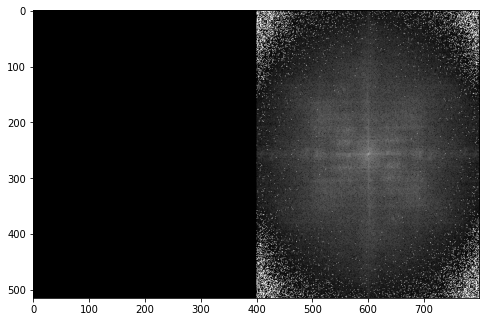

In [18]:
# Imprimir el espectro

f = fft.fft2(im)
fshift = fft.fftshift(f)
mag_spectrum = 20*np.log(np.abs(fshift))
mag_spectrum = np.asarray(mag_spectrum, dtype=np.uint8)
img_mag = np.concatenate((im, mag_spectrum), axis=1)

plt.subplots(figsize=(8, 8))
plt.imshow(img_mag, cmap="gray")

In [19]:
def do(img):
  # Normal to fourier
  f = fft.fft2(img)
  fs = fft.fftshift(f)
  real = fs.real
  phases = fs.imag
  
  # Proceso 
  kf = 0.49
  real2 = real.copy()
  r, c = real2.shape

  real2[int(r*kf):int(r*(1-kf)), :] = 0 
  real2[:, int(c*kf):int(c*(1-kf))] = 0
  
  # Regreso fourier a noraml
  fs2 = np.empty(real.shape, dtype=complex)
  fs2.real = real2
  fs2.imag = phases
  f2 = fft.ifftshift(fs2)
  img2 = fft.ifft2(f2)
  img2 = np.abs(img2)

  # Imprimir los gráficos
  plt.subplots(figsize=(12, 12))
  plt.subplot(221)
  plt.imshow(img, cmap='gray')  # Imagen original
  plt.subplot(222)
  plt.imshow(real, norm=LogNorm(vmin=5), cmap='gray') # Espectro original
  plt.subplot(223)
  plt.imshow(real2, norm=LogNorm(vmin=5), cmap='gray') # Espectro corregido
  plt.subplot(224)
  plt.imshow(img2, cmap='gray') # Imagen final
  plt.show()

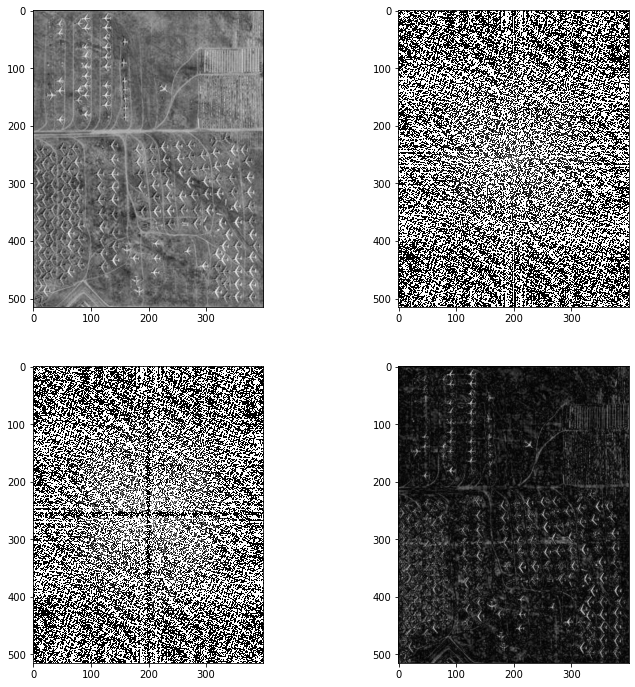

In [20]:
do(im)